# Bitcoin analysis - Modelo predictivo

## Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import time
import statsmodels.api as sm
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import gc
%matplotlib inline

## Obtención y tratamiento de datos

Los datos obtenidos mediante el proceso de scraping en paralelo desde la web de la API de Binance, son guardados en formato CSV, para poderlos importar de manera sencilla. Dicho CSV se actualiza cada hora, para tener la información más actual en cada momento añadiendo los registros al fichero.

In [65]:
dffull = pd.read_csv("../data/fulldata.csv", index_col=0)
dffull.index = pd.to_datetime(dffull.index)
dffull = new_features(dffull)
dffull = dffull.reset_index()
dffull = get_technical_indicators(dffull, 60)
dffull = dffull.dropna()
dffull.drop(["open", "high", "low", "closetime", "Ethereum", "ETH", "subjectivity", "close"], axis = 1, inplace=True)
dffull.index = pd.to_datetime(dffull["index"])
dffull.drop(["index"], axis = 1, inplace=True)

# Convert to binary objective variable (Clasification)
#mask = dffull.difmin > 0
#column_name = 'difmin'
#dffull.loc[mask, column_name] = 0
#mask = np.invert(mask)
#dffull.loc[mask, column_name] = 1

In [7]:
dffull.head(5)

,ntrades,quote-volume,taker-base-vol,taker-quote-vol,volume,Bitcoin,BTC,Blockchain,Cryptocurrency,polarity,volatily,difmin,close-high,MA_60,EMA_60,RSI_60,Force_60,STD_60
index,,,,,,,,,,,,,,,,,,
2018-06-03 21:45:00,810,54728.094370,4.743536,36462.135873,7.121236,80,19,68,70,0.267863,0.000780,-0.000033,-0.916667,7709.212833,7705.703870,0.309907,-8.745551,9.165847
2018-06-03 21:46:00,1286,241836.480565,18.471709,141996.502891,31.462290,66,13,46,60,0.276611,0.000911,0.000138,-0.945714,7708.967333,7705.069697,0.319317,-266.810367,9.511127
2018-06-03 21:47:00,1010,283567.830627,24.801039,190530.925932,36.912388,80,8,59,56,0.280103,0.001208,-0.001142,0.890205,7708.569667,7704.133066,0.308404,-417.483311,10.201997
2018-06-03 21:50:00,99,24653.337031,2.472736,19002.357121,3.208501,80,14,65,54,0.237244,0.001184,0.000651,-0.381738,7708.226667,7703.421116,0.305054,89.290796,10.641068
2018-06-03 21:51:00,89,44951.724106,2.027997,15583.651997,5.851766,71,16,73,50,0.285202,0.001033,-0.000130,-0.745592,7707.826500,7702.701623,0.297976,31.795170,11.091656


In [14]:
dffull.shape

(10508, 18)

### Featuring engineering

A partir de la información original podemos extraer nueva información implícita en los datos que pueda ayudar a obtener un mejor acierto en el modelo.

Los campos que obtienen son los siguientes:

* Volatilidad: Se entiende como: $\frac{max-min}{apertura}$
* Diferencia porcentual por período(Diferencia por minuto): en proporción respecto al precio de apertura $\frac{cierre-apertura}{apertura}$
* Relación cierre-máximo: Considera el maximo con el cierre y su valor mínimo $2·\frac{max-cierre}{max-min}-1$

In [4]:
def new_features(dffull):
    """Given a dataframe, return a new one 
    with additional information containded in the old"""

    kwargs = {"volatily": lambda x: (x["high"]-x["low"])/x["open"]}
    dffull = dffull.assign(**kwargs)

    kwargs = {"difmin": lambda x: (x["close"]-x["open"])/x["open"]}
    dffull = dffull.assign(**kwargs)

    kwargs = {"close-high": lambda x: (2*(x["high"]-x["close"]))/(x["high"] - x["low"]) - 1}
    dffull = dffull.assign(**kwargs)
    
    #kwargs = {"money-flow": lambda x: (((x["high"]+x["low"] + x["close"])/(3))*x["volume"])}
    #dffull = dffull.assign(**kwargs)
    
    return dffull

## Normalización y preparación de los datos

Es recomendable normalizar los datos de manera que esten en escalas lo mas cercanas posible. Además, si existen valores NAN, deberemos ver si se eliminan, o bien se rellenan con algún valor. En nuestro caso, usaremos el reemplazo con la media de la columna donde falten dichos valores.

Eliminamos las columnas redundantes y sobre las que hemos generado información nueva y de manera conjunta.

In [59]:
dffull.drop(["open", "high", "low", "closetime", "Ethereum", "ETH", "subjectivity"], axis = 1, inplace=True)

### Escalado Min-Max

Una parte fundamental para el correcto aprendizaje de modelos de datos como las redes neuronales es el escalado de los datos pues, generalmente, las variables estan en una escala diferente. Por ello, es necesario realizar un escalado a valores normalizados, como se ha realizado en este caso mediante el metodo Min-Max.

In [17]:
dffull.head(5)

,ntrades,quote-volume,taker-base-vol,taker-quote-vol,volume,Bitcoin,BTC,Blockchain,Cryptocurrency,polarity,volatily,difmin,close-high,MA_60,EMA_60,RSI_60,Force_60,STD_60
index,,,,,,,,,,,,,,,,,,
2018-06-03 21:45:00,0.255696,0.012451,0.015239,0.015539,0.010441,0.714286,0.319149,0.659574,0.70,0.553308,0.042525,0.408725,-0.916667,7709.212833,7705.703870,0.309907,-8.745551,9.165847
2018-06-03 21:46:00,0.406329,0.055027,0.059341,0.060512,0.046136,0.514286,0.191489,0.425532,0.60,0.572055,0.049626,0.415504,-0.945714,7708.967333,7705.069697,0.319317,-266.810367,9.511127
2018-06-03 21:47:00,0.318987,0.064523,0.079674,0.081196,0.054128,0.714286,0.085106,0.563830,0.56,0.579537,0.065875,0.364591,0.890205,7708.569667,7704.133066,0.308404,-417.483311,10.201997
2018-06-03 21:50:00,0.030696,0.005607,0.007944,0.008098,0.004703,0.714286,0.212766,0.627660,0.54,0.487690,0.064529,0.435919,-0.381738,7708.226667,7703.421116,0.305054,89.290796,10.641068
2018-06-03 21:51:00,0.027532,0.010226,0.006515,0.006641,0.008579,0.585714,0.255319,0.712766,0.50,0.590464,0.056320,0.404843,-0.745592,7707.826500,7702.701623,0.297976,31.795170,11.091656


In [10]:
scaler=MinMaxScaler()
dffull[dffull.columns[0:12]] = scaler.fit_transform(dffull[dffull.columns[0:12]])
#dffull[dffull.columns] = scaler.inverse_transform(dffull)

In [ ]:
dffull[dffull.columns[0:12]] = scaler.inverse_transform(dffull[dffull.columns[0:12]])

### Comprobación de campos nulos

El modelo no funcionará correctamente si contiene valores nulos o vacios, por ello debemos asegurarnos de la consistencia de los datos.

In [6]:
dffull.isnull().any()

ntrades            False
quote-volume       False
taker-base-vol     False
taker-quote-vol    False
volume             False
Bitcoin            False
BTC                False
Blockchain         False
Cryptocurrency     False
polarity           False
volatily           False
difmin             False
close-high         False
MA_60              False
EMA_60             False
RSI_60             False
Force_60           False
STD_60             False
dtype: bool

En caso de existir valores nulos, debemos realizar los pertinentes ajustes.

In [34]:
dffull = dffull.dropna()

In [35]:
dffull.shape

(10390, 51)

## Descomposición de la serie de datos

En primera instancia podemos realizar una pequeña aproximación de los datos a partir de ver parámetros como:
* Estacionalidad
* Tendencia
* Residuos
* Observado

In [8]:
s = sm.tsa.seasonal_decompose(dffull.difmin.values[0:500], freq=60)

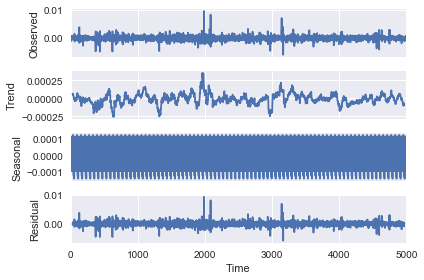

In [7]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(dffull.difmin.values[0:5000], freq=60)
resplot = res.plot() 
plt.show(resplot)

In [69]:
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

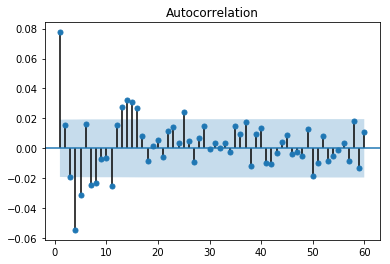

In [7]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dffull.difmin.values.squeeze(), lags=60, zero=False)
pyplot.show()

In [27]:
a

[]

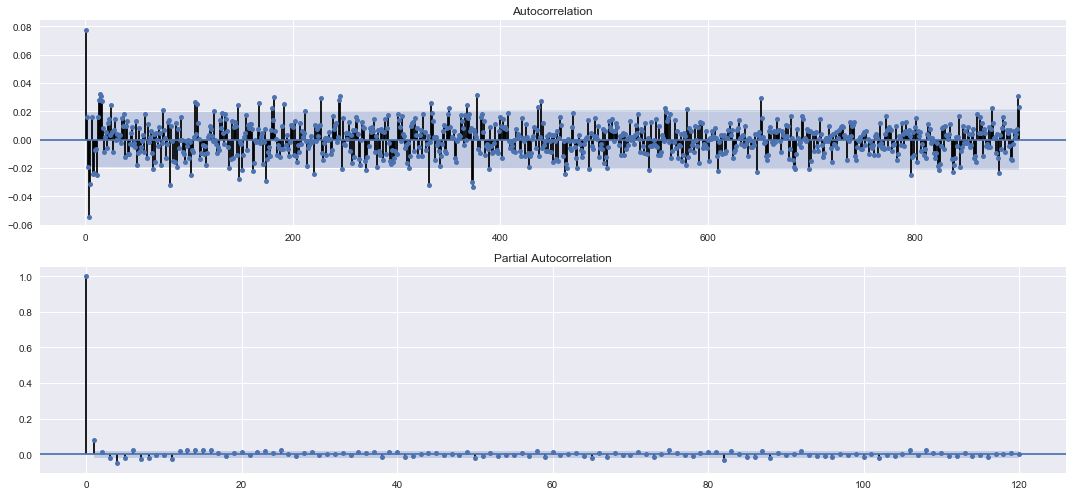

In [37]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dffull.difmin.values.squeeze(), lags=900, ax=ax, zero=False)
ax = plt.subplot(212)
a = sm.graphics.tsa.plot_pacf(dffull.difmin.values.squeeze(), lags=120, ax=ax)
plt.tight_layout()
plt.show()

## Tendencias

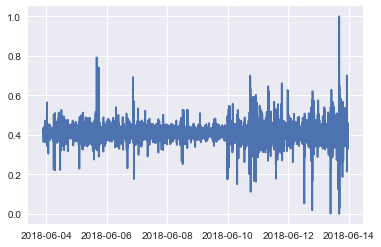

In [13]:
plt.plot(dffull["difmin"])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1108a2978>,
      dtype=object)

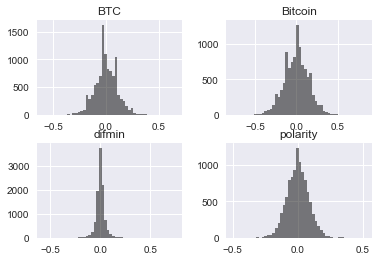

In [19]:
dffull[["Cryptocurrency", "Bitcoin", "difmin", "polarity", "BTC"]].diff().hist(color='k', alpha=0.5, bins=50)

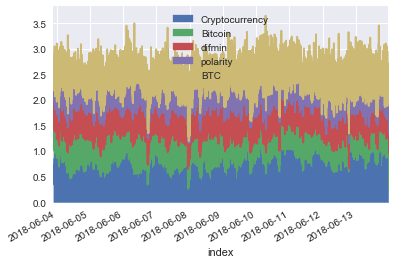

In [23]:
dffull[["Cryptocurrency", "Bitcoin", "difmin", "polarity", "BTC"]].plot.area()

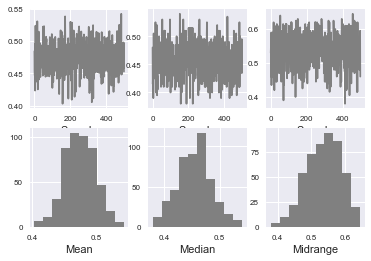

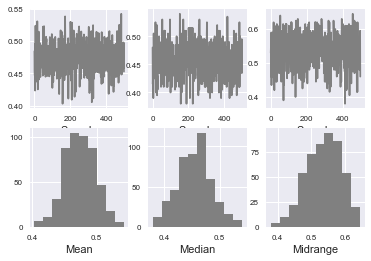

In [26]:
from pandas.plotting import bootstrap_plot
bootstrap_plot(dffull["Cryptocurrency"], size=50, samples=500, color='grey')

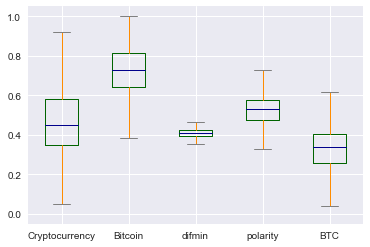

In [27]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
dffull[["Cryptocurrency", "Bitcoin", "difmin", "polarity", "BTC"]].plot.box(color=color, sym='r+')

In [ ]:
plt.plot(dffull["polarity"])
plt.plot(dffull["BTC"])
plt.plot(dffull["Bitcoin"])

## Correlación de los datos

,ntrades,quote-volume,taker-base-vol,taker-quote-vol,volume,Bitcoin,BTC,Blockchain,Cryptocurrency,polarity,volatily,difmin,close-high,MA_60,EMA_60,RSI_60,Force_60,STD_60
ntrades,1.000000,0.623030,0.509669,0.509715,0.620113,-0.005521,-0.009771,-0.085312,0.086503,-0.012535,0.551849,-0.084350,-0.051507,0.027032,0.024028,-0.327852,-0.381468,0.383086
quote-volume,0.623030,1.000000,0.865797,0.865051,0.996246,0.022228,-0.061095,-0.084082,0.102654,-0.063340,0.699705,-0.141651,0.034870,-0.127989,-0.130532,-0.181135,-0.506785,0.386362
taker-base-vol,0.509669,0.865797,1.000000,0.995983,0.868971,0.029082,-0.055099,-0.084173,0.103787,-0.080675,0.628502,0.066458,-0.039177,-0.164921,-0.166871,-0.101376,-0.407553,0.343893
taker-quote-vol,0.509715,0.865051,0.995983,1.000000,0.861148,0.025879,-0.040963,-0.075022,0.083001,-0.060914,0.604663,0.066215,-0.039636,-0.114202,-0.116051,-0.091648,-0.387330,0.324280
volume,0.620113,0.996246,0.868971,0.861148,1.000000,0.025082,-0.074590,-0.092193,0.122587,-0.082345,0.721092,-0.142507,0.033959,-0.176833,-0.179468,-0.188376,-0.526472,0.404506
Bitcoin,-0.005521,0.022228,0.029082,0.025879,0.025082,1.000000,0.228863,0.092052,0.102172,-0.005592,0.029694,0.019122,-0.005835,-0.080651,-0.080818,0.006162,-0.003141,0.060457
BTC,-0.009771,-0.061095,-0.055099,-0.040963,-0.074590,0.228863,1.000000,0.119553,-0.170938,0.160973,-0.124755,0.008837,0.002261,0.260649,0.260642,-0.042549,0.041248,-0.135106
Blockchain,-0.085312,-0.084082,-0.084173,-0.075022,-0.092193,0.092052,0.119553,1.000000,-0.005650,0.084055,-0.109483,0.009470,0.012849,0.184982,0.184536,0.002446,0.042191,-0.138438
Cryptocurrency,0.086503,0.102654,0.103787,0.083001,0.122587,0.102172,-0.170938,-0.005650,1.000000,-0.166813,0.167106,-0.000065,-0.013268,-0.330923,-0.331573,-0.054703,-0.095621,0.212953
polarity,-0.012535,-0.063340,-0.080675,-0.060914,-0.082345,-0.005592,0.160973,0.084055,-0.166813,1.000000,-0.140640,0.008775,-0.018161,0.359392,0.359816,0.041790,0.038377,-0.096992


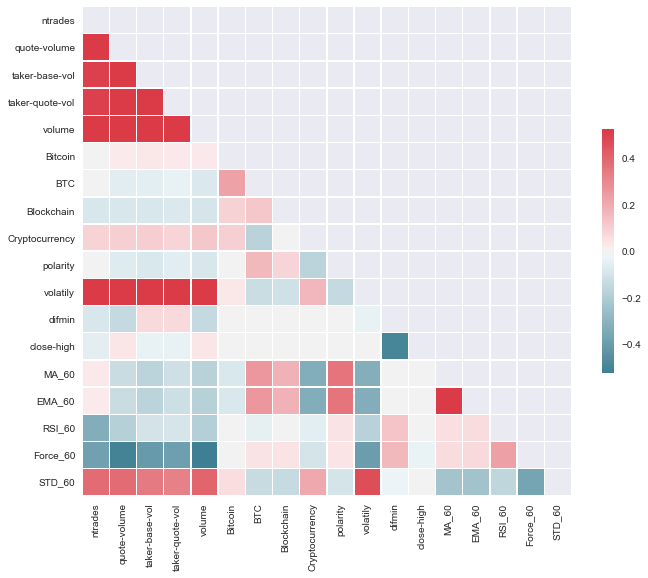

In [8]:
# Getting and showing correlation matrix
corr = dffull.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr

## Distribución de los datos

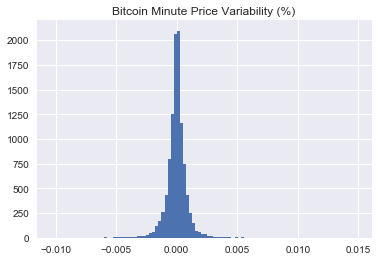

In [13]:
fig, ax1 = plt.subplots(1,1)
ax1.hist(dffull['difmin'].values, bins=100)
ax1.set_title('Bitcoin Minute Price Variability (%)')
plt.show()

## Preparación conjunto de datos

Para la preparación de los conjuntos de entrenamiento y validación, realizaremos un corte donde los registros correspondientes a los 4 primeros días formarán el conjunto de entrenamiento, el día restante, nos servira como conjunto de validación.

In [9]:
training_set, test_set = dffull[dffull.index < "2018-06-13 04:00:00"], dffull[dffull.index >= "2018-06-13 04:00:00"]

In [26]:
training_set.isnull().any()

ntrades            False
quote-volume       False
taker-base-vol     False
taker-quote-vol    False
volume             False
Bitcoin            False
BTC                False
Blockchain         False
Cryptocurrency     False
polarity           False
volatily           False
difmin             False
close-high         False
MA_60              False
EMA_60             False
RSI_60             False
Force_60           False
STD_60             False
dtype: bool

## Preparación de los datos en ventanas

In [10]:
# Training
window_len = 25
LSTM_training_inputs = []
LSTM_training_outputs = training_set["difmin"].values
training_set = training_set.drop("difmin", axis = 1)
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)

nelems = len(LSTM_training_inputs)
LSTM_training_outputs = preprocessing.scale(LSTM_training_outputs[:nelems])

# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [preprocessing.scale(np.array(LSTM_training_input)) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#LSTM_training_inputs = preprocessing.scale(LSTM_training_inputs)
#LSTM_training_outputs = preprocessing.scale(LSTM_training_outputs)

In [11]:
# Test
LSTM_test_inputs = []
LSTM_test_outputs = test_set["difmin"].values
test_set = test_set.drop("difmin", axis = 1)
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set)

nelems2 = len(LSTM_test_inputs)
LSTM_test_outputs = preprocessing.scale(LSTM_test_outputs[:nelems2])

LSTM_test_inputs = [preprocessing.scale(np.array(LSTM_test_inputs)) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

### Preparación de los datos de entrenamiento-validación

Deberemos estructurar los datos para que puedan ser procesados por el modelo de red neuronal posterior

In [73]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = training_set.drop("close", axis = 1)
LSTM_training_inputs = np.array(LSTM_training_inputs)
LSTM_training_outputs = training_set["close"].values

LSTM_test_inputs = test_set.drop("close", axis = 1)
LSTM_test_inputs = np.array(LSTM_test_inputs)
LSTM_test_outputs = test_set["close"].values

In [74]:
LSTM_training_inputs = np.reshape(LSTM_training_inputs, 
                                  (LSTM_training_inputs.shape[0], 
                                   1,
                                   LSTM_training_inputs.shape[1]))

In [29]:
LSTM_training_inputs.shape

(9483, 7, 17)

In [76]:
LSTM_test_inputs = np.reshape(LSTM_test_inputs, 
                                  (LSTM_test_inputs.shape[0], 
                                   1, 
                                   LSTM_test_inputs.shape[1]))

In [30]:
LSTM_test_inputs.shape

(1011, 7, 17)

# Long-Short Term Memory - Neural Network

La red neuronal utilizada para la obtención del modelo de datos ha sido configurada con las siguientes características:

* Neuronas LSTM de entrada.
* Capa oculta para evitar overfitting.
* Capa oculta con 6 nodos.
* Capa con 1 salida.

In [94]:
model.compile??

Object `model.compile` not found.


In [196]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers

def build_model(inputs, output_size, neurons, activ_func="tanh",
                dropout=0.5, loss="mean_squared_error", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences= True, input_shape = (inputs.shape[1], inputs.shape[2])))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=6, activation="relu"))
    #model.add(Dense(units=output_size, activation="sigmoid"))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    #sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)
    model.compile(loss=loss, optimizer=optimizer, metrics = ["accuracy"])
    return model


In [67]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="elu",
                dropout=1.5, loss="mean_squared_error", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(LSTM(neurons))
    model.add(Dropout(0.3, noise_shape=None, seed=None))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.2, noise_shape=None, seed=None))
    model.add(Dense(50, activation = "relu"))
    model.add(Dense(units=output_size, activation="sigmoid"))
    model.add(Activation(activ_func))
    
    #sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)
    #sgd = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    #sgd = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #sgd = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    #sgd = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    sgd = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(loss=loss, optimizer=sgd, metrics = ["accuracy"])
    model.summary()
    return model

In [26]:
neurons = 256                
activation_function = 'tanh'  
loss = 'mse'                  
optimizer="RMSprop"              
dropout = 0.5                 
batch_size = 32             
epochs = 50                
window_len = 25               
training_size = 0.8
merge_date = '2016-01-01'

from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, 
                activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activation_function))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activation_function))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activation_function))
  #sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae', "mse"])
  model.summary()
  return model

### Entrenamiento del modelo

In [27]:
gc.collect()
# random seed for reproducibility
np.random.seed(2018)

# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons = neurons)

# model output is next price normalised to 10th previous closing price
#LSTM_training_outputs = training_set['close'].values
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False,
                            validation_data = (LSTM_test_inputs, LSTM_test_outputs))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 25, 256)           280576    
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 256)           525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
__________

9465/9465 [==============================] - 79s 8ms/step - loss: 0.5294 - mean_absolute_error: 0.4190 - mean_squared_error: 0.5294 - val_loss: 0.6393 - val_mean_absolute_error: 0.4621 - val_mean_squared_error: 0.6393
Epoch 31/50
9465/9465 [==============================] - 79s 8ms/step - loss: 0.5270 - mean_absolute_error: 0.4191 - mean_squared_error: 0.5270 - val_loss: 0.6681 - val_mean_absolute_error: 0.4639 - val_mean_squared_error: 0.6681
Epoch 32/50
9465/9465 [==============================] - 79s 8ms/step - loss: 0.5195 - mean_absolute_error: 0.4129 - mean_squared_error: 0.5195 - val_loss: 0.6701 - val_mean_absolute_error: 0.4717 - val_mean_squared_error: 0.6701
Epoch 33/50
9465/9465 [==============================] - 79s 8ms/step - loss: 0.5137 - mean_absolute_error: 0.4067 - mean_squared_error: 0.5137 - val_loss: 0.6558 - val_mean_absolute_error: 0.4765 - val_mean_squared_error: 0.6558
Epoch 34/50
9465/9465 [==============================] - 78s 8ms/step - loss: 0.5049 - mean_

### Visualización del error por iteración

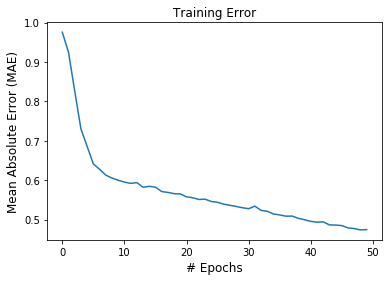

In [18]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Training Error')

ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

### Visualización específica de período

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import datetime

split_date = "2018-05-14"

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2018) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2018) for j in [1,5,9]])
ax1.plot(training_set.index,
         training_set['close'], label='Actual')
ax1.plot(training_set.index,
         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['close'].values)[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_training_inputs))+1)-\
            (training_set['close'].values)/(training_set['close'].values))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.5, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2018,2018) for j in [1,5,9]])
axins.plot(training_set.index,
         training_set['close'], label='Actual')
axins.plot(training_set.index,
         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['close'].values)[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2018, 5, 1), datetime.date(2018, 6, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()


# Training prediction

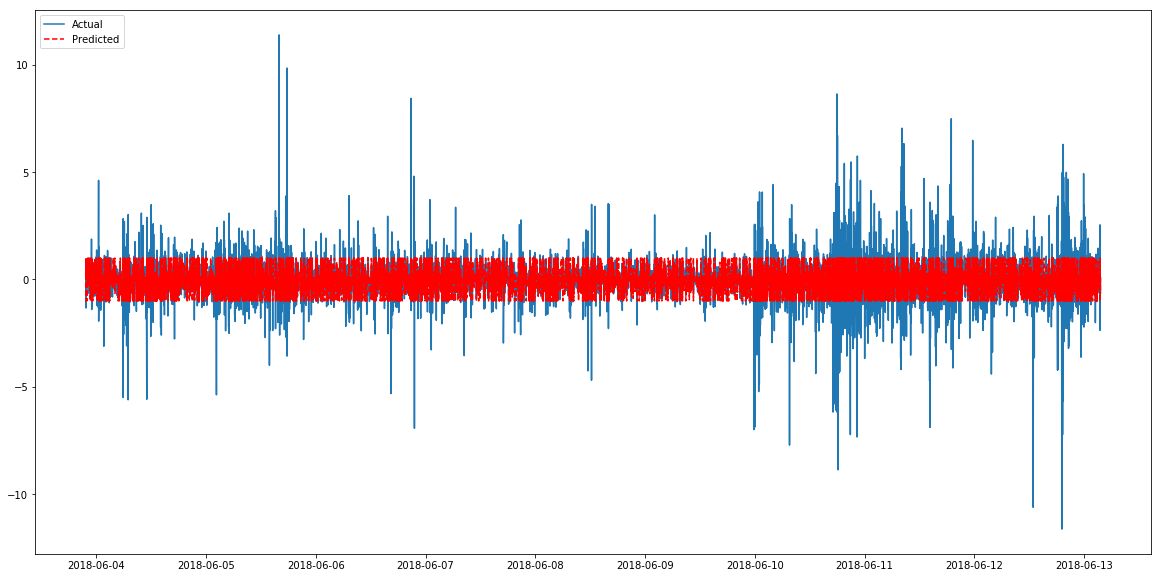

In [19]:
predicted = btc_model.predict(LSTM_training_inputs)
plt.figure(figsize=(20,10))
plt.plot(training_set[:nelems].index,LSTM_training_outputs, label = 'Actual')
plt.plot(training_set[:nelems].index,predicted,'r--', label='Predicted')
plt.legend(loc='upper left')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import datetime

predicted = btc_model.predict(LSTM_training_inputs)
fig, ax1 = plt.subplots(figsize=[30,20])
ax1.plot(training_set.index,training_set["close"], label = 'Actual')
ax1.plot(training_set.index,predicted,'r--', label='Predicted')
ax1.legend(loc='upper left')

axins = zoomed_inset_axes(ax1, 2, loc=5) # zoom-factor: 3.35, location: centre
axins.plot(training_set.index, training_set['close'], label='Actual')
axins.plot(training_set.index, predicted, label='Predicted')
axins.set_xlim([datetime.datetime(2018, 3, 31, 8, 0, 0), datetime.datetime(2018, 4, 2, 20, 0, 0)])
axins.set_ylim([0.50,0.75])
mark_inset(ax1, axins, loc1=1, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()

## Evaluación del modelo

# Test prediction

Una vez ajustado el modelo, probamos el conjunto de prueba para verificar la precisión del modelo.

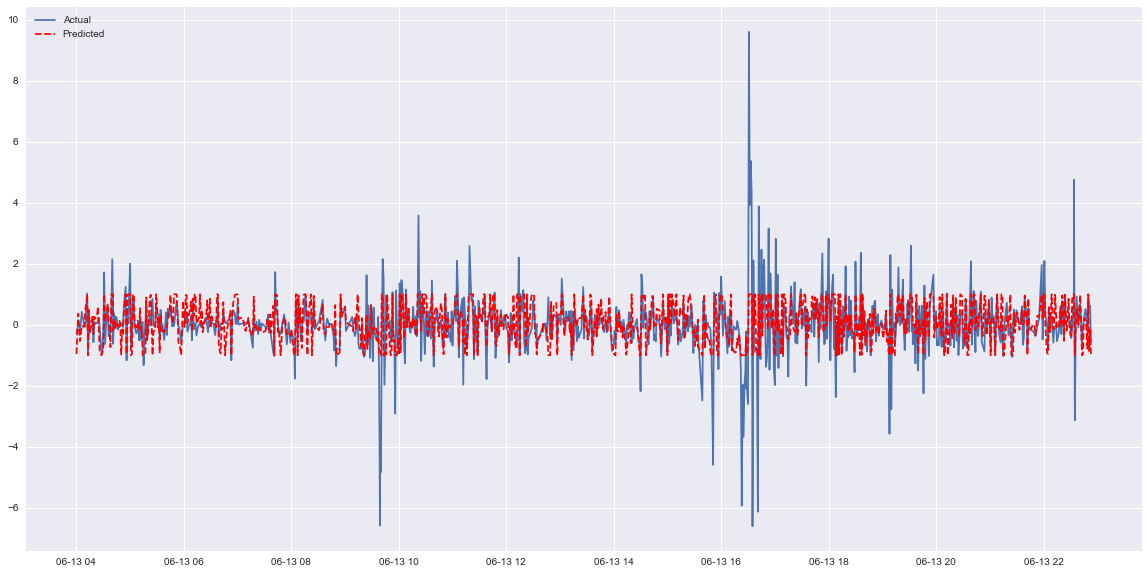

In [22]:
predicted = btc_model.predict(LSTM_test_inputs)
plt.figure(figsize=(20,10))
plt.plot(test_set.index[:nelems2],LSTM_test_outputs, label = 'Actual')
plt.plot(test_set.index[:nelems2],predicted,'r--', label='Predicted')
plt.legend(loc='upper left')
plt.show()

In [32]:
btc_model.evaluate(LSTM_training_inputs, LSTM_training_outputs)

9465/9465 [==============================] - 25s 3ms/step


[0.4388756150268589, 0.33367535486400157, 0.4388756150268589]

In [34]:
btc_model.evaluate(LSTM_test_inputs, LSTM_test_outputs)

993/993 [==============================] - 3s 3ms/step


[0.7069627914403276, 0.5039492921466674, 0.7069627914403276]

Además, vemos como el loss es incluso más bajo que el cometido durante el entrenamiento. Cierto es que puede deberse a la causalidad de los datos.

# CGU

In [241]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint

def build_model(inputs, activ_func="linear",
                dropout=0.5, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(Conv1D(activation='relu', input_shape=(inputs.shape[1], inputs.shape[2]), strides=3, filters=8, kernel_size=20))
    model.add(Dropout(dropout))
    model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))
    model.compile(loss=loss, optimizer=optimizer)
    return model
    

In [ ]:
# random seed for reproducibility
np.random.seed(2018)

# initialise model architecture
btc_model = build_model(LSTM_training_inputs)

# model output is next price normalised to 10th previous closing price
#LSTM_training_outputs = training_set['close'].values
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=32, verbose=2, shuffle=True)

# GRU

In [141]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import GRU
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.5, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(GRU(neurons, input_shape = (inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=6, activation="relu"))
    model.add(Dense(units=output_size, activation="sigmoid"))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model



In [142]:
# random seed for reproducibility
np.random.seed(2018)

# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons = 128)

# model output is next price normalised to 10th previous closing price
#LSTM_training_outputs = training_set['close'].values
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs,
                            epochs=100, batch_size=64, verbose=2, shuffle=True)

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()



Epoch 1/100
 - 4s - loss: 0.1441
Epoch 2/100
 - 2s - loss: 0.1344
Epoch 3/100
 - 2s - loss: 0.1308
Epoch 4/100
 - 2s - loss: 0.1301
Epoch 5/100
 - 2s - loss: 0.1298
Epoch 6/100
 - 2s - loss: 0.1292
Epoch 7/100
 - 2s - loss: 0.1271
Epoch 8/100
 - 2s - loss: 0.1246
Epoch 9/100
 - 2s - loss: 0.1189
Epoch 10/100
 - 2s - loss: 0.1161
Epoch 11/100
 - 2s - loss: 0.1154
Epoch 12/100
 - 2s - loss: 0.1140
Epoch 13/100
 - 2s - loss: 0.1134
Epoch 14/100
 - 2s - loss: 0.1123
Epoch 15/100
 - 2s - loss: 0.1117
Epoch 16/100
 - 2s - loss: 0.1109
Epoch 17/100
 - 3s - loss: 0.1108
Epoch 18/100
 - 3s - loss: 0.1095
Epoch 19/100
 - 2s - loss: 0.1101
Epoch 20/100
 - 2s - loss: 0.1087
Epoch 21/100
 - 3s - loss: 0.1085
Epoch 22/100
 - 3s - loss: 0.1067
Epoch 23/100
 - 2s - loss: 0.1072
Epoch 24/100
 - 2s - loss: 0.1085
Epoch 25/100
 - 2s - loss: 0.1054
Epoch 26/100
 - 2s - loss: 0.1051
Epoch 27/100
 - 2s - loss: 0.1066
Epoch 28/100
 - 2s - loss: 0.1047
Epoch 29/100
 - 2s - loss: 0.1029
Epoch 30/100
 - 2s - lo

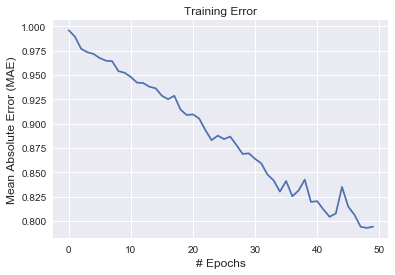

In [15]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Training Error')

ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

# Training prediction

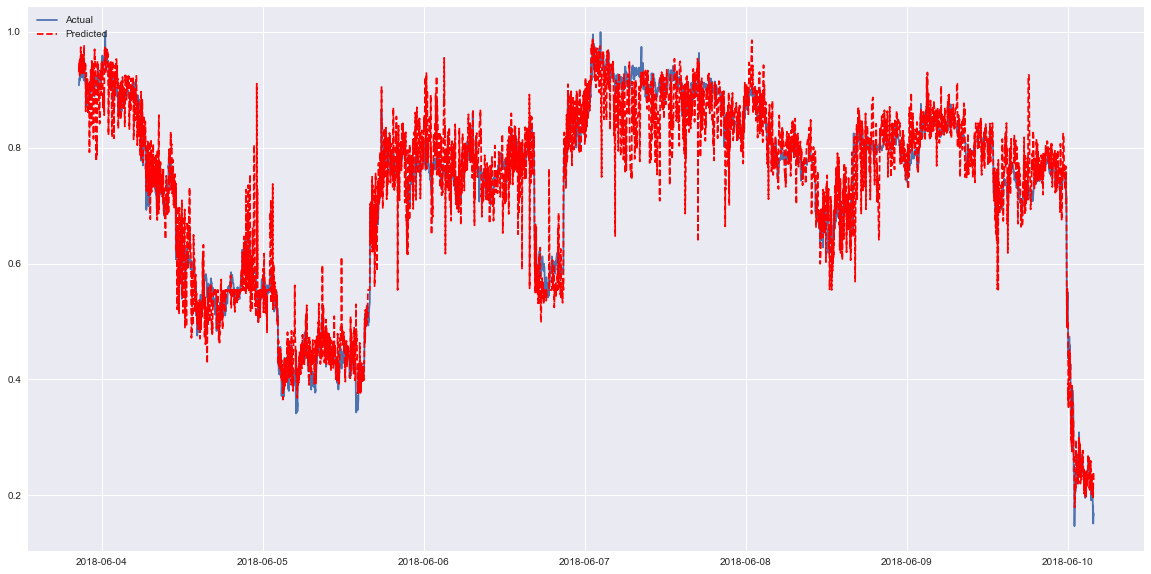

In [144]:
predicted = btc_model.predict(LSTM_training_inputs)
plt.figure(figsize=(20,10))
plt.plot(training_set.index[:6023],LSTM_training_outputs, label = 'Actual')
plt.plot(training_set.index[:6023],predicted,'r--', label='Predicted')
plt.legend(loc='upper left')

# Test prediction

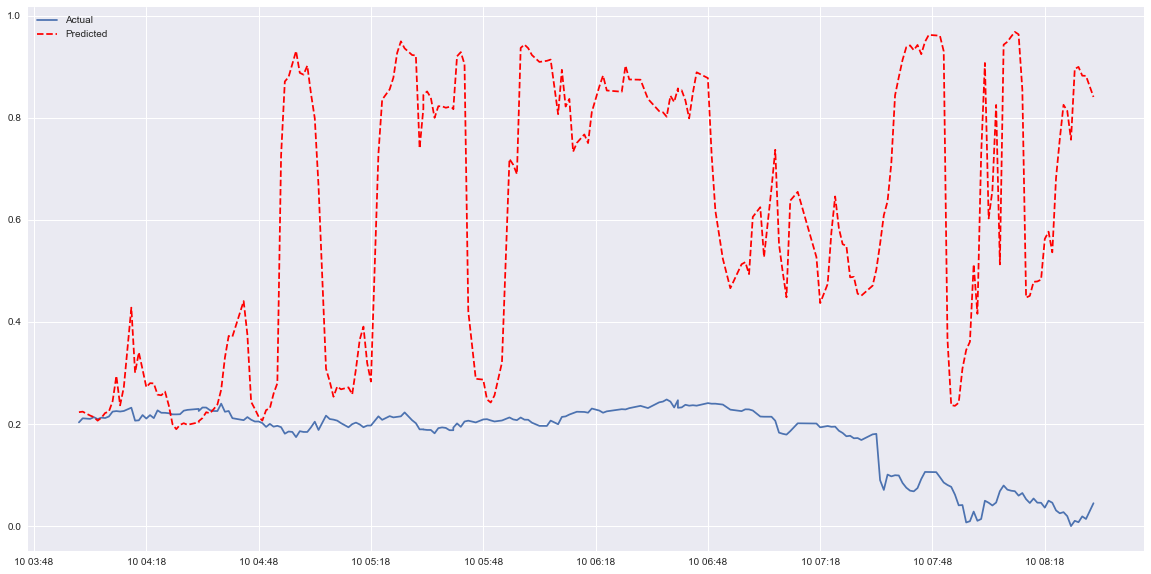

In [145]:
predicted = btc_model.predict(LSTM_test_inputs)
plt.figure(figsize=(20,10))
plt.plot(test_set.index[:230],LSTM_test_outputs, label = 'Actual')
plt.plot(test_set.index[:230],predicted,'r--', label='Predicted')
plt.legend(loc='upper left')
plt.show()

In [250]:
#LSTM_test_outputs = test_set['close'].values
btc_model.evaluate(LSTM_test_inputs, LSTM_test_outputs)

374/374 [==============================] - 1s 2ms/step


0.028937910847804126

## Preparación datos modelos

In [37]:
dffull.head(5)

,ntrades,quote-volume,taker-base-vol,taker-quote-vol,volume,Bitcoin,BTC,Blockchain,Cryptocurrency,polarity,volatily,difmin,close-high,MA_60,EMA_60,RSI_60,Force_60,STD_60
index,,,,,,,,,,,,,,,,,,
2018-06-03 21:45:00,810,54728.094370,4.743536,36462.135873,7.121236,80,19,68,70,0.267863,0.000780,-0.000033,-0.916667,7709.212833,7705.703870,0.309907,-8.745551,9.165847
2018-06-03 21:46:00,1286,241836.480565,18.471709,141996.502891,31.462290,66,13,46,60,0.276611,0.000911,0.000138,-0.945714,7708.967333,7705.069697,0.319317,-266.810367,9.511127
2018-06-03 21:47:00,1010,283567.830627,24.801039,190530.925932,36.912388,80,8,59,56,0.280103,0.001208,-0.001142,0.890205,7708.569667,7704.133066,0.308404,-417.483311,10.201997
2018-06-03 21:50:00,99,24653.337031,2.472736,19002.357121,3.208501,80,14,65,54,0.237244,0.001184,0.000651,-0.381738,7708.226667,7703.421116,0.305054,89.290796,10.641068
2018-06-03 21:51:00,89,44951.724106,2.027997,15583.651997,5.851766,71,16,73,50,0.285202,0.001033,-0.000130,-0.745592,7707.826500,7702.701623,0.297976,31.795170,11.091656


In [34]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
#Load data
X, y = dffull.drop("difmin", axis=1), dffull["difmin"]
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# Regresión Lineal

In [40]:
LinearRegression??

In [35]:
from sklearn.linear_model import LinearRegression

btc_model = LinearRegression()
btc_model.fit(X_train, y_train)
predicted = btc_model.predict(X_train)
mse = mean_squared_error(y_train, btc_model.predict(X_train))
print("MSE: %.8f" % mse)
print(btc_model.score(X_train, y_train))
print(btc_model.score(X_test, y_test))

MSE: 0.17094956
0.3153832434773187
0.3552099926495894


In [14]:
from sklearn.linear_model import LogisticRegression

btc_model = LogisticRegression()
btc_model.fit(X_train, y_train)
predicted = btc_model.predict(X_train)
mse = mean_squared_error(y_train, btc_model.predict(X_train))
print("MSE: %.4f" % mse)
print(btc_model.score(X_train, y_train))
print(btc_model.score(X_test, y_test))

y_pred = btc_model.predict(X_test)
print(classification_report(y_test, y_pred))

MSE: 0.4102
0.58982764090092
0.6355851569933397
             precision    recall  f1-score   support

        0.0       0.61      0.62      0.61       494
        1.0       0.66      0.65      0.65       557

avg / total       0.64      0.64      0.64      1051



### Training

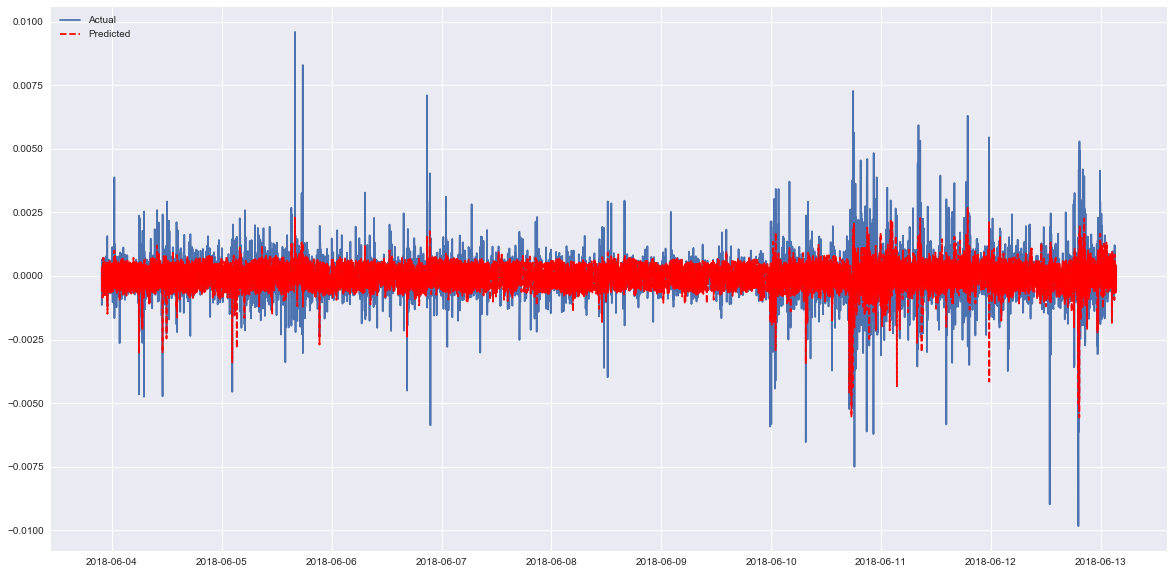

In [126]:
plt.figure(figsize=(20,10))
plt.plot(X_train.index,y_train, label = 'Actual')
plt.plot(X_train.index,predicted,'r--', label='Predicted')
plt.legend(loc='upper left')

### Test

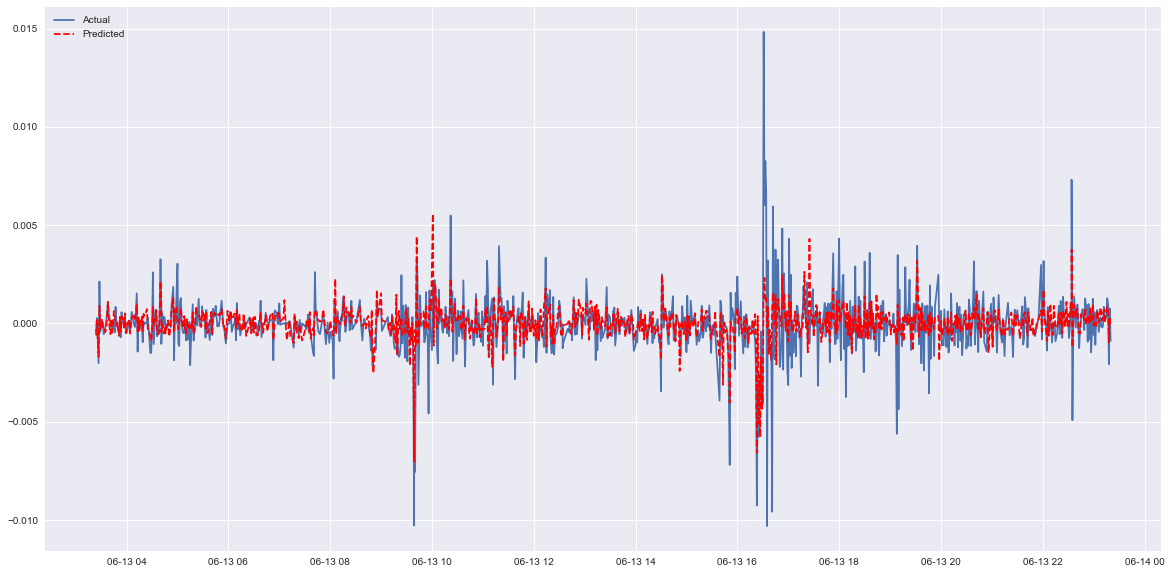

In [127]:
predicted = btc_model.predict(X_test)
plt.figure(figsize=(20,10))
plt.plot(X_test.index, y_test, label = 'Actual')
plt.plot(X_test.index, predicted,'r--', label='Predicted')
plt.legend(loc='upper left')
plt.show()

In [136]:
btc_model.score(X_test, y_test)

0.6355851569933397

## FB-Project

In [82]:
dffull.head()

,Unnamed: 0,ntrades,quote-volume,taker-base-vol,taker-quote-vol,volume,Bitcoin,BTC,Blockchain,Cryptocurrency,polarity,volatily,difmin,close-high,MA_60,EMA_60,RSI_60,Force_60,STD_60
0,2018-06-03 21:45:00,810,54728.094370,4.743536,36462.135873,7.121236,80,19,68,70,0.267863,0.000780,-0.000033,-0.916667,7709.212833,7705.703870,0.309907,-8.745551,9.165847
1,2018-06-03 21:46:00,1286,241836.480565,18.471709,141996.502891,31.462290,66,13,46,60,0.276611,0.000911,0.000138,-0.945714,7708.967333,7705.069697,0.319317,-266.810367,9.511127
2,2018-06-03 21:47:00,1010,283567.830627,24.801039,190530.925932,36.912388,80,8,59,56,0.280103,0.001208,-0.001142,0.890205,7708.569667,7704.133066,0.308404,-417.483311,10.201997
3,2018-06-03 21:50:00,99,24653.337031,2.472736,19002.357121,3.208501,80,14,65,54,0.237244,0.001184,0.000651,-0.381738,7708.226667,7703.421116,0.305054,89.290796,10.641068
4,2018-06-03 21:51:00,89,44951.724106,2.027997,15583.651997,5.851766,71,16,73,50,0.285202,0.001033,-0.000130,-0.745592,7707.826500,7702.701623,0.297976,31.795170,11.091656


In [50]:
import fbprophet
# Prophet requires columns ds (Date) and y (value)
dffull = dffull.rename(columns={'Unnamed: 0': 'ds', 'difmin': 'y'})
# Put market cap in billions
#gm['y'] = gm['y'] / 1e9
# Make the prophet model and fit on the data
dffull_prophet = fbprophet.Prophet(changepoint_prior_scale=0.5)
dffull_prophet.fit(dffull)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [53]:
# Make a future dataframe for 2 years
dffull_forecast = dffull_prophet.make_future_dataframe(periods=300, freq='T')
# Make predictions
dffull_forecast = dffull_prophet.predict(dffull_forecast)

### Changepoints

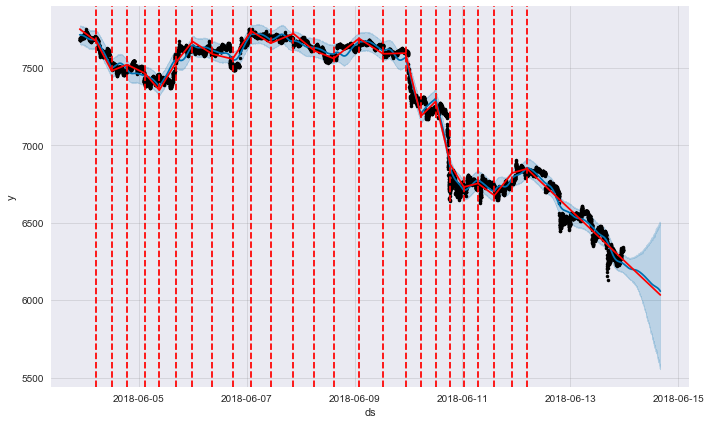

In [102]:
from fbprophet.plot import add_changepoints_to_plot
fig = dffull_prophet.plot(dffull_forecast)
a = add_changepoints_to_plot(fig.gca(), dffull_prophet, dffull_forecast)

### Forecast

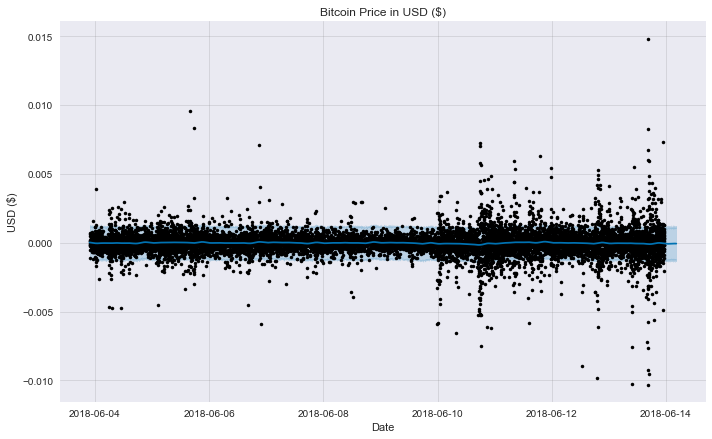

In [54]:
dffull_prophet.plot(dffull_forecast, xlabel = 'Date', ylabel = 'USD ($)')
plt.title('Bitcoin Price in USD ($)');


In [ ]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(dffull)
    
    future = model.make_future_dataframe(periods=300, freq='T')
    future = model.predict(future)
    
    dffull[changepoint] = future['yhat']

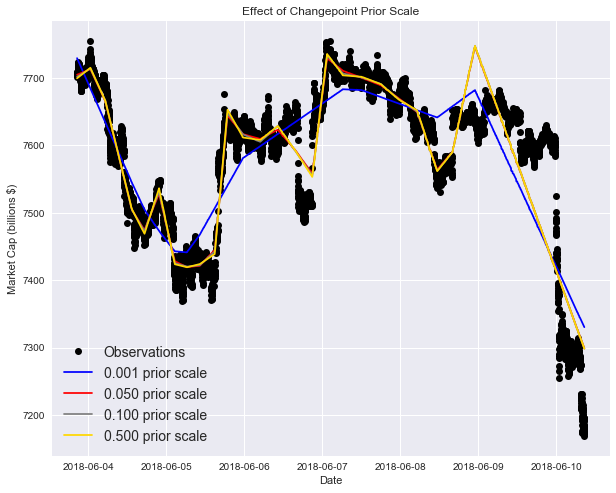

In [35]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(pd.to_datetime(dffull['ds']), dffull['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(dffull['ds'], dffull[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

### Trend and daily

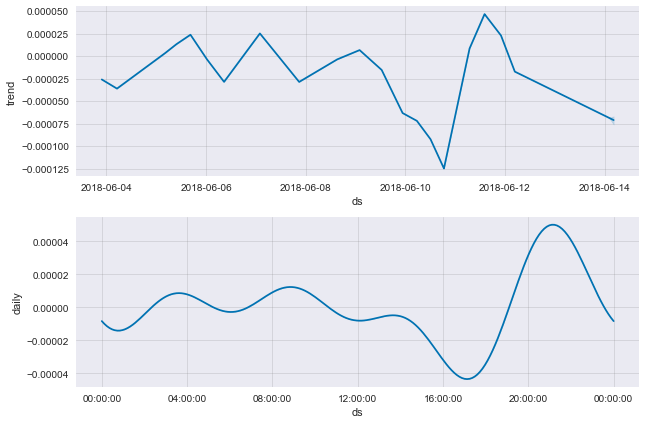

In [55]:
pcomp = dffull_prophet.plot_components(dffull_forecast)

## Gradient boosting

In [66]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
#Load data
X, y = dffull.drop("difmin", axis=1), dffull["difmin"]
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [84]:
ensemble.GradientBoostingRegressor??

In [63]:
# Fit regression model
params = {'n_estimators': 64, 'max_depth': 32, 'min_samples_split': 16,
          'learning_rate': 0.05, 'random_state': 2018,'min_samples_leaf': 8}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_train, clf.predict(X_train))
mae = mean_absolute_error(y_train, clf.predict(X_train))
print("MSE: %8f" % mse)
print("MAE: %8f" % mae)
print(clf.score(X_train, y_train))

MSE: 0.000000
MAE: 0.000251
0.8376069736596674


In [44]:
print(clf.score(X_test, y_test))

0.5858654540851675


### Training

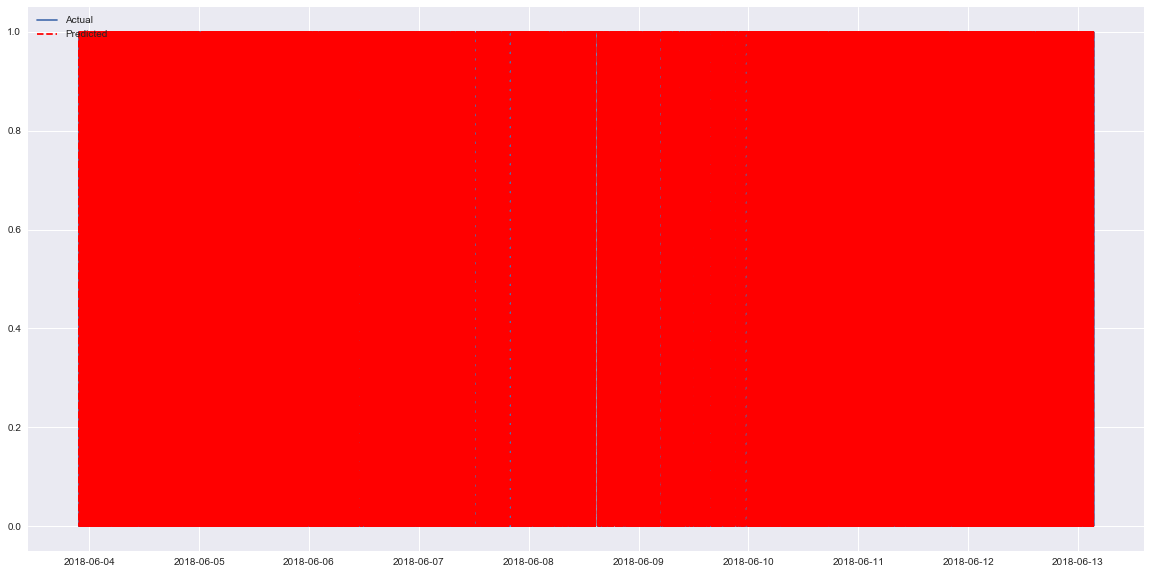

In [30]:
predicted = clf.predict(X_train)
plt.figure(figsize=(20,10))
plt.plot(X_train.index,y_train, label = 'Actual')
plt.plot(X_train.index,predicted,'r--', label='Predicted')
plt.legend(loc='upper left')

### Test

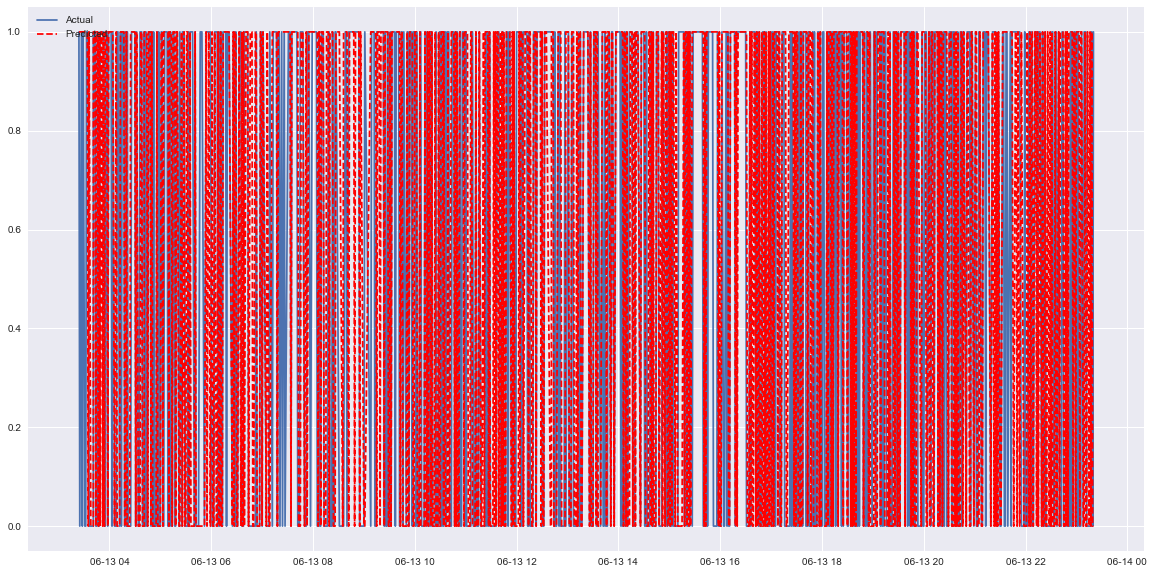

In [31]:
predicted = clf.predict(X_test)
plt.figure(figsize=(20,10))
plt.plot(X_test.index,y_test, label = 'Actual')
plt.plot(X_test.index,predicted,'r--', label='Predicted')
plt.legend(loc='upper left')

### Deviance

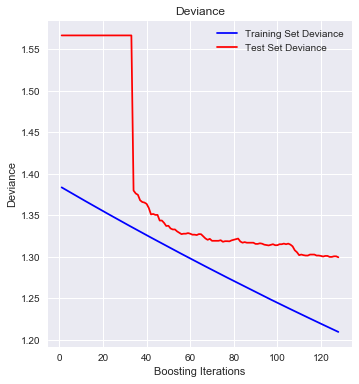

In [32]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

### Feature importance

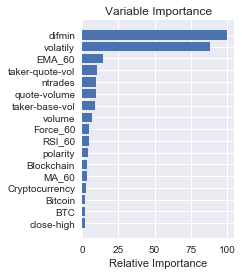

In [105]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, dffull.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Gradient boosting classifier

In [88]:
# Fit regression model
params = {'n_estimators': 128, 'max_depth': 32, 'min_samples_split': 16,
          'learning_rate': 0.001, 'random_state': 2018,'min_samples_leaf': 4}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_train, clf.predict(X_train))
print("MSE: %8f" % mse)
print(clf.score(X_train, y_train))

MSE: 0.081033
0.9189666893269884


In [77]:
predicted = clf.predict(X_train)
confusion_matrix(y_train, predicted)

array([[3249,  276],
       [  65, 3765]])

In [78]:
from sklearn.metrics           import *
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

        0.0       0.98      0.92      0.95      3525
        1.0       0.93      0.98      0.96      3830

avg / total       0.96      0.95      0.95      7355



In [79]:
predicted = clf.predict(X_test)
print(clf.score(X_test, y_test))
confusion_matrix(y_test, predicted)

0.7117031398667936


array([[1016,  518],
       [ 391, 1228]])

In [80]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.72      0.66      0.69      1534
        1.0       0.70      0.76      0.73      1619

avg / total       0.71      0.71      0.71      3153



## Random Forest

In [81]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics           import *

params = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 20, 5),
          'min_samples_leaf': range(2, 40, 5)}

#classifier = RandomForestClassifier(random_state=2018, class_weight='balanced')
#randomForest = GridSearchCV(estimator=classifier, param_grid=params, cv=None, scoring='roc_auc')
#randomForest.fit(X_train, y_train)
#print(randomForest.best_params_)
# Output: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4}

randomForest = RandomForestClassifier(random_state=2018, class_weight='balanced', 
                                      max_depth = 9, min_samples_leaf = 2, min_samples_split = 2)
#randomForest = RFECV(randomForest_setup, step = 1, cv = 5, scoring='roc_auc', n_jobs = 4)
randomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=2018,
            verbose=0, warm_start=False)

In [82]:
y_pred = randomForest.predict(X_train)
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

        0.0       0.80      0.80      0.80      3525
        1.0       0.82      0.82      0.82      3830

avg / total       0.81      0.81      0.81      7355



In [56]:
y_pred = randomForest.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.73      0.80      0.76       494
        1.0       0.81      0.73      0.77       557

avg / total       0.77      0.76      0.76      1051



## Boosting + Log Reg

In [83]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics           import *

logreg = LogisticRegression(random_state=2018)
boostedLogReg = AdaBoostClassifier(logreg, random_state = 2018)
boostedLogReg.fit(X_train, y_train)

y_pred = boostedLogReg.predict(X_train)
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

        0.0       0.73      0.74      0.74      3525
        1.0       0.76      0.75      0.76      3830

avg / total       0.75      0.75      0.75      7355



In [84]:

y_pred = boostedLogReg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.75      0.76      0.75      1534
        1.0       0.77      0.75      0.76      1619

avg / total       0.76      0.76      0.76      3153



## ARIMA

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In fu

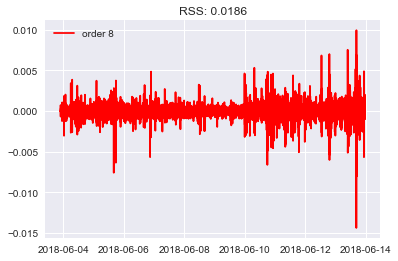

In [14]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot


model = ARIMA(dffull["difmin"], order=(8, 1, 0))  
results_AR = model.fit(disp=-1)  
#plt.plot(ts_diff_logtrans)
plt.plot(results_AR.fittedvalues, color='red', label = 'order 8')
RSS = results_AR.fittedvalues-dffull["difmin"]
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc = 'best')

In [19]:
pred = results_AR.predict(start=67, end=10507)

/Users/justoherreroamoros/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



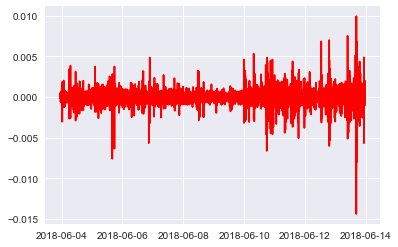

In [20]:
plt.plot(pred, color='red', label = 'order 8')

## Technical analysis

In [5]:
def get_technical_indicators(df, nperiods):
    
    df = moving_average(df, nperiods)
    df = exponential_moving_average(df, nperiods)
    #df = momentum(df, nperiods)
    #df = rate_of_change(df, nperiods)
    #df = average_true_range(df, nperiods)
    #df = bollinger_bands(df, nperiods)
    #df = ppsr(df)
    #df = stochastic_oscillator_k(df)
    #df = stochastic_oscillator_d(df, nperiods)
    #df = trix(df, nperiods)
    #df = macd(df, nperiods, nperiods/2)
    #df = mass_index(df)
    #df = vortex_indicator(df, nperiods)
    df = relative_strength_index(df, nperiods)
    #df = money_flow_index(df, nperiods)
    #df = on_balance_volume(df, nperiods)
    df = force_index(df, nperiods)
    #df = ease_of_movement(df, nperiods)
    #df = commodity_channel_index(df, nperiods)
    df = standard_deviation(df, nperiods)
    return df



def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['close'].diff(n - 1)
    N = df['close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def average_true_range(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    return df


def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df


def ppsr(df):
    """Calculate Pivot Points, Supports and Resistances for given data
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    PP = pd.Series((df['high'] + df['low'] + df['close']) / 3)
    R1 = pd.Series(2 * PP - df['low'])
    S1 = pd.Series(2 * PP - df['high'])
    R2 = pd.Series(PP + df['high'] - df['low'])
    S2 = pd.Series(PP - df['high'] + df['low'])
    R3 = pd.Series(df['high'] + 2 * (PP - df['low']))
    S3 = pd.Series(df['low'] - 2 * (df['high'] - PP))
    psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
    PSR = pd.DataFrame(psr)
    df = df.join(PSR)
    return df


def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['close'] - df['low']) / (df['high'] - df['low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['close'] - df['low']) / (df['high'] - df['low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


def trix(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    return df


def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def mass_index(df):
    """Calculate the Mass Index for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    Range = df['high'] - df['low']
    EX1 = Range.ewm(span=9, min_periods=9).mean()
    EX2 = EX1.ewm(span=9, min_periods=9).mean()
    Mass = EX1 / EX2
    MassI = pd.Series(Mass.rolling(25).sum(), name='Mass Index')
    df = df.join(MassI)
    return df


def vortex_indicator(df, n):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'high'] - df.loc[i, 'low']) - abs(df.loc[i + 1, 'low'] - df.loc[i, 'high'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df


def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    """Calculate KST Oscillator for given data.
    
    :param df: pandas.DataFrame
    :param r1: 
    :param r2: 
    :param r3: 
    :param r4: 
    :param n1: 
    :param n2: 
    :param n3: 
    :param n4: 
    :return: pandas.DataFrame
    """
    M = df['close'].diff(r1 - 1)
    N = df['close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['close'].diff(r2 - 1)
    N = df['close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['close'].diff(r3 - 1)
    N = df['close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['close'].diff(r4 - 1)
    N = df['close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df


def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


def true_strength_index(df, r, s):
    """Calculate True Strength Index (TSI) for given data.
    
    :param df: pandas.DataFrame
    :param r: 
    :param s: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['close'] - df['high'] - df['low']) / (df['high'] - df['low']) * df['volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['close'] - df['high'] - df['low']) / (df['high'] - df['low']) * df['volume']
    Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
    df = df.join(Chaikin)
    return df


def money_flow_index(df, n):
    """Calculate Money Flow Index and Ratio for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['high'] + df['low'] + df['close']) / 3
    i = 0
    PosMF = [0]
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    return df


def on_balance_volume(df, n):
    """Calculate On-Balance volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'close'] - df.loc[i, 'close'] > 0:
            OBV.append(df.loc[i + 1, 'volume'])
        if df.loc[i + 1, 'close'] - df.loc[i, 'close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'close'] - df.loc[i, 'close'] < 0:
            OBV.append(-df.loc[i + 1, 'volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    return df


def force_index(df, n):
    """Calculate Force Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    F = pd.Series(df['close'].diff(n) * df['volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df


def ease_of_movement(df, n):
    """Calculate Ease of Movement for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EoM = (df['high'].diff(1) + df['low'].diff(1)) * (df['high'] - df['low']) / (2 * df['volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['high'] + df['low'] + df['close']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


def coppock_curve(df, n):
    """Calculate Coppock Curve for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['close'].diff(int(n * 11 / 10) - 1)
    N = df['close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['close'].diff(int(n * 14 / 10) - 1)
    N = df['close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df


def keltner_channel(df, n):
    """Calculate Keltner Channel for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    KelChM = pd.Series(((df['high'] + df['low'] + df['close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['high'] - 2 * df['low'] + df['close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['high'] + 4 * df['low'] + df['close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df


def ultimate_oscillator(df):
    """Calculate Ultimate Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    BP_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'close'] - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                 pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    return df


def donchian_channel(df, n):
    """Calculate donchian channel of given pandas data frame.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    dc_l = []
    while i < n - 1:
        dc_l.append(0)
        i += 1

    i = 0
    while i + n - 1 < df.index[-1]:
        dc = max(df['high'].ix[i:i + n - 1]) - min(df['low'].ix[i:i + n - 1])
        dc_l.append(dc)
        i += 1

    donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
    donchian_chan = donchian_chan.shift(n - 1)
    return df.join(donchian_chan)


def standard_deviation(df, n):
    """Calculate Standard Deviation for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.join(pd.Series(df['close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
    return df